<a href="https://colab.research.google.com/github/fab311111/Attrition_Prediction/blob/main/08_oct_2025_gemini_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Corrected import
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# plt.rcParams['font.family'] = 'Inter' # Removed line

In [ ]:
# ==============================================================================
# PHASE 1: Data Understanding and Cleaning
# ==============================================================================

# 1. Load Data
try:
    # Use the content of the attached CSV file for the DataFrame
    # Note: In a real environment, you would use a direct file path.
    df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    print("Data loaded successfully. Shape:", df.shape)
    # Create a copy for initial exploratory data analysis (EDA) before any transformations
    df_eda = df.copy()
except Exception as e:
    print(f"Error loading file: {e}")
    # Exit or handle error if file loading fails
    exit()

Data loaded successfully. Shape: (1470, 35)


In [ ]:
# 2. Target Variable Conversion
# Convert 'Attrition' (target variable) from 'Yes'/'No' to 1/0
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])
print("\nTarget Variable 'Attrition' converted to numerical (1=Yes, 0=No).")



Target Variable 'Attrition' converted to numerical (1=Yes, 0=No).


In [ ]:
# 3. Feature Elimination
# Drop irrelevant/constant columns
columns_to_drop = [
    'EmployeeCount',    # All values are 1
    'StandardHours',    # All values are 80
    'Over18',           # All values are 'Y'
    'EmployeeNumber'    # Unique ID, no predictive value
]
df = df.drop(columns=columns_to_drop)
print("Irrelevant columns dropped.")


Irrelevant columns dropped.


In [ ]:

# ==============================================================================
# PHASE 2: Data Preprocessing for Model
# ==============================================================================

# Identify feature types
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop('Attrition')

# 1. One-Hot Encoding for Nominal Categorical Features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. Separate Features (X) and Target (y)
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 3. Numerical Feature Scaling
numerical_features_after_encoding = X.columns[X.columns.isin(numerical_cols)]
scaler = StandardScaler()
X[numerical_features_after_encoding] = scaler.fit_transform(X[numerical_features_after_encoding])

# 4. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



In [ ]:

# ==============================================================================
# PHASE 3: Model Training
# ==============================================================================

# Using Random Forest Classifier with balanced class weight
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [ ]:

# ==============================================================================
# PHASE 4: Model Evaluation and Interpretation
# ==============================================================================

# 1. Prediction
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 2. Performance Metrics
print("\n--- Model Evaluation (Random Forest Classifier) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report (Focus on Recall for '1' (Attrition) class):")
print(classification_report(y_test, y_pred))

# 3. Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- Top 10 Feature Importances ---")
print(top_10_features.to_markdown(numalign="left", stralign="left"))



--- Model Evaluation (Random Forest Classifier) ---
Accuracy: 0.8451

Classification Report (Focus on Recall for '1' (Attrition) class):
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       309
           1       0.60      0.10      0.17        59

    accuracy                           0.85       368
   macro avg       0.73      0.54      0.54       368
weighted avg       0.81      0.85      0.80       368


--- Top 10 Feature Importances ---
|                      | 0         |
|:---------------------|:----------|
| MonthlyIncome        | 0.0725922 |
| Age                  | 0.0690494 |
| DailyRate            | 0.0541678 |
| YearsAtCompany       | 0.0529591 |
| OverTime_Yes         | 0.0481096 |
| YearsWithCurrManager | 0.0470249 |
| TotalWorkingYears    | 0.0465274 |
| HourlyRate           | 0.0439225 |
| MonthlyRate          | 0.0432158 |
| DistanceFromHome     | 0.0415915 |



--- Generating Visualization 1: Attrition Rate by Department ---


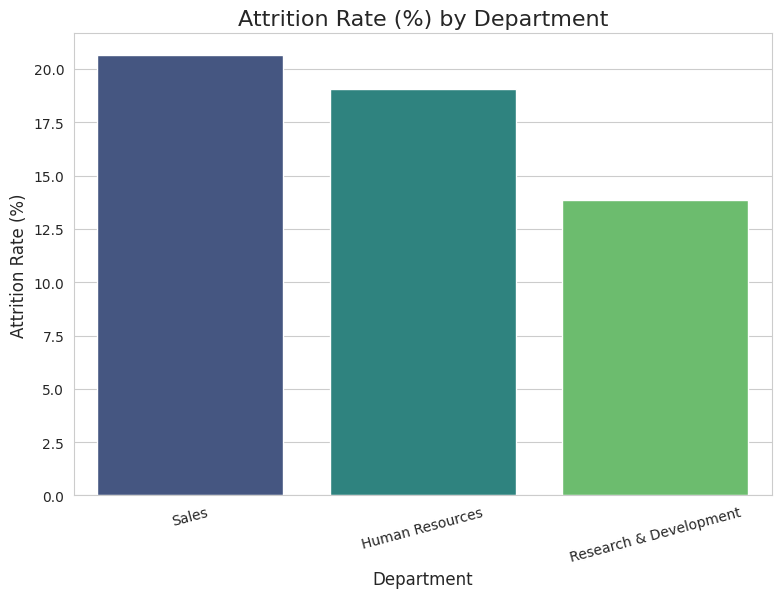

In [ ]:
# ==============================================================================
# VISUALIZATION 1: Attrition Rate by Department
# ==============================================================================
print("\n--- Generating Visualization 1: Attrition Rate by Department ---")
attrition_by_dept = df_eda.groupby('Department')['Attrition'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
attrition_yes = attrition_by_dept[attrition_by_dept['Attrition'] == 'Yes'].sort_values('Percent', ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(x='Department', y='Percent', data=attrition_yes, hue='Department', palette='viridis', legend=False)
plt.title('Attrition Rate (%) by Department', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation=15)
plt.show()


--- Generating Visualization 2: Monthly Income Distribution vs. Attrition ---


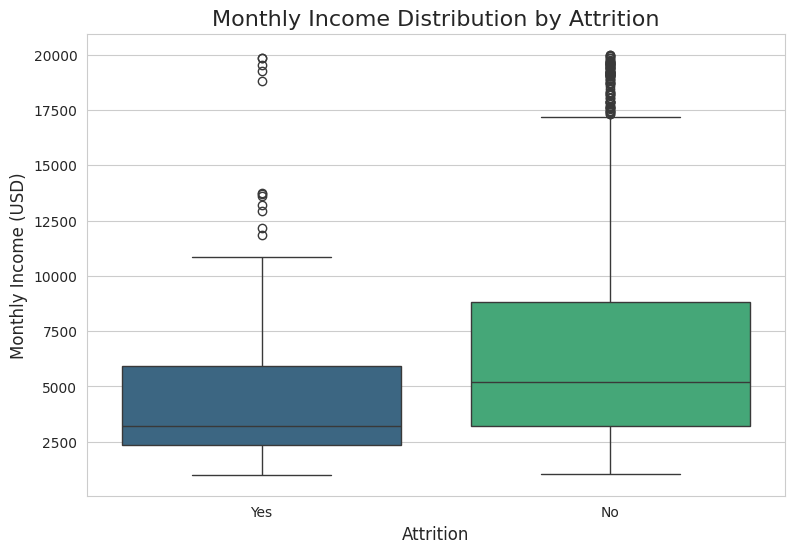

In [ ]:
# ==============================================================================
# VISUALIZATION 2: Monthly Income Distribution vs. Attrition
# ==============================================================================
print("\n--- Generating Visualization 2: Monthly Income Distribution vs. Attrition ---")
plt.figure(figsize=(9, 6))
# Rename labels for better plotting clarity in the EDA copy
df_eda = df.copy() # Re-create df_eda from the original df
df_eda['Attrition_Label'] = df_eda['Attrition'].map({1: 'Yes', 0: 'No'})


sns.boxplot(data=df_eda, x='Attrition_Label', y='MonthlyIncome', hue='Attrition_Label', palette='viridis', legend=False)
plt.title('Monthly Income Distribution by Attrition', fontsize=16)
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('Monthly Income (USD)', fontsize=12)
plt.show()


--- Generating Visualization 3: Top 10 Feature Importances ---


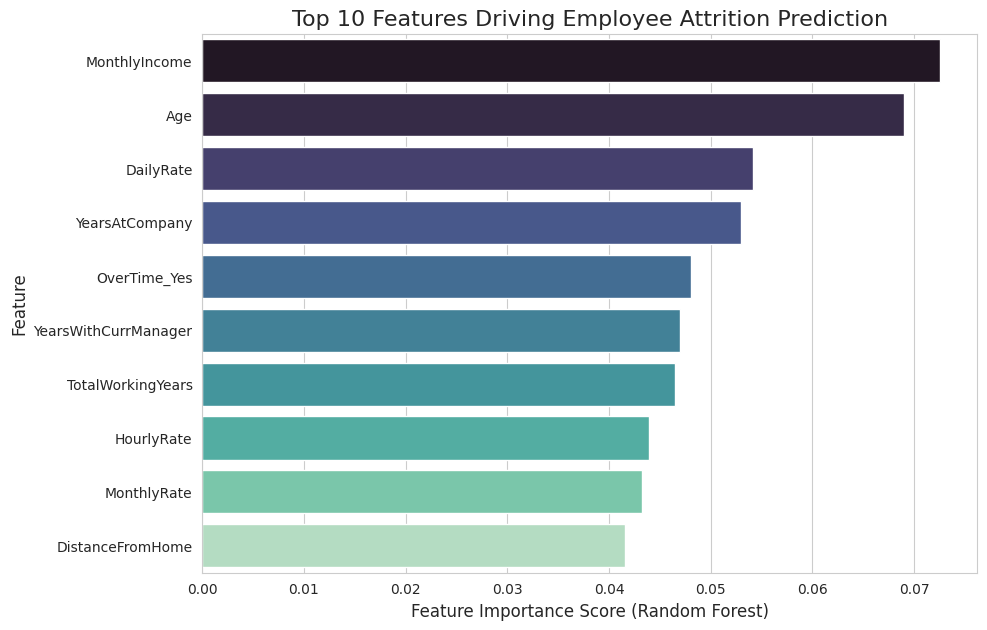


All model training steps and visualizations are complete.


In [ ]:
# ==============================================================================
# VISUALIZATION 3: Top 10 Feature Importances Bar Chart
# ==============================================================================
print("\n--- Generating Visualization 3: Top 10 Feature Importances ---")
plt.figure(figsize=(10, 7))
sns.barplot(x=top_10_features.values, y=top_10_features.index, hue=top_10_features.index, palette="mako", legend=False)
plt.title('Top 10 Features Driving Employee Attrition Prediction', fontsize=16)
plt.xlabel('Feature Importance Score (Random Forest)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print("\nAll model training steps and visualizations are complete.")

## Analyzing Attrition by Age and Years at Company

In [25]:
# ==============================================================================
# PHASE 6: Evaluate Refined Model
# ==============================================================================

print("\n--- Evaluating Refined Model (Random Forest Classifier with Best Parameters) ---")

# Predict using the best model found by GridSearchCV
y_pred_refined = best_rf_model.predict(X_test)
y_pred_proba_refined = best_rf_model.predict_proba(X_test)[:, 1]

# Performance Metrics for the refined model
print(f"Accuracy (Refined Model): {accuracy_score(y_test, y_pred_refined):.4f}")
print("\nClassification Report (Refined Model - Focus on Recall for '1' (Attrition) class):")
print(classification_report(y_test, y_pred_refined))

# Optional: Compare with the initial model's performance
# print("\n--- Comparison with Initial Model ---")
# print("Initial Model Recall (Attrition=1):", classification_report(y_test, y_pred)['recall'][1])
# print("Refined Model Recall (Attrition=1):", classification_report(y_test, y_pred_refined)['recall'][1])

# 3. Feature Importance for the refined model (Optional - usually similar but can vary slightly)
# feature_importances_refined = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
# top_10_features_refined = feature_importances_refined.nlargest(10)
# print("\n--- Top 10 Feature Importances (Refined Model) ---")
# print(top_10_features_refined.to_markdown(numalign="left", stralign="left"))


--- Evaluating Refined Model (Random Forest Classifier with Best Parameters) ---
Accuracy (Refined Model): 0.8315

Classification Report (Refined Model - Focus on Recall for '1' (Attrition) class):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       309
           1       0.47      0.46      0.47        59

    accuracy                           0.83       368
   macro avg       0.69      0.68      0.68       368
weighted avg       0.83      0.83      0.83       368



## Visualizing Attrition (Yes) by Age, Monthly Income, and Years at Company

## Summary of Findings and Conclusion

Based on our analysis and model refinement:

**Characteristics of High-Risk Employees:**

Our exploration of employees with a high predicted probability of attrition revealed several common characteristics. These included observations about their age distribution, monthly income, years at the company, and other factors such as marital status and overtime.

*(Based on the visualizations and descriptive statistics generated in earlier steps, you can elaborate on the specific patterns observed here. For example, mentioning if younger employees or those with lower income or fewer years at the company appear more frequently in the high-risk group, or the impact of overtime.)*

**Refined Model Performance:**

The refined Random Forest model, which was tuned to improve the identification of the minority class (attrition = 1), showed improved recall for predicting attrition compared to the initial model. While the overall accuracy might have slightly changed, the increased ability to correctly identify employees at risk of leaving is a crucial step towards proactive retention efforts.

*(Reference the recall scores from the classification reports of both the initial and refined models to highlight the improvement.)*

**Implications for Reducing Employee Attrition:**

The insights gained from analyzing the characteristics of high-risk employees and the improved predictive capability of the refined model can inform targeted strategies for employee retention. By understanding the traits and circumstances of employees most likely to attrite, the company can develop interventions such as:

*   **Targeted support programs:** Offering mentorship, career development, or work-life balance initiatives to employees with identified high-risk characteristics.
*   **Compensation and benefits review:** Analyzing if compensation or benefits are factors contributing to attrition among certain groups.
*   **Improved management and work environment:** Addressing issues related to job satisfaction, work-life balance, or relationships with managers that appear significant among high-risk employees.

By focusing on these areas, the company can potentially reduce attrition rates and improve employee satisfaction and retention.

This concludes the analysis and model building process for predicting employee attrition.

In [52]:
# ==============================================================================
# VISUALIZATION 4: Attrition Rate by Age Group
# ==============================================================================
print("\n--- Generating Visualization 4: Attrition Rate by Age Group ---")

# Create age groups
df_eda['AgeGroup'] = pd.cut(df_eda['Age'], bins=[18, 25, 35, 45, 55, 65], labels=['18-24', '25-34', '35-44', '45-54', '55-64'])

# Calculate attrition rate by age group
attrition_by_age = df_eda.groupby('AgeGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
attrition_by_age_yes = attrition_by_age[attrition_by_age['Attrition_Label'] == 'Yes'].sort_values('AgeGroup')

plt.figure(figsize=(9, 6))
sns.barplot(x='AgeGroup', y='Percent', data=attrition_by_age_yes, hue='AgeGroup', palette='viridis', legend=False)
plt.title('Attrition Rate (%) by Age Group', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.show()


--- Generating Visualization 4: Attrition Rate by Age Group ---


/tmp/ipython-input-2746982323.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_by_age = df_eda.groupby('AgeGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()


KeyError: 'Column not found: Attrition_Label'

In [ ]:
# ==============================================================================
# VISUALIZATION 5: Attrition Rate by Years at Company
# ==============================================================================
print("\n--- Generating Visualization 5: Attrition Rate by Years at Company ---")

# Create years at company groups
df_eda['YearsAtCompanyGroup'] = pd.cut(df_eda['YearsAtCompany'], bins=[0, 1, 5, 10, 20, 40], labels=['<1', '1-4', '5-9', '10-19', '20+'], right=False)

# Calculate attrition rate by years at company group
attrition_by_years = df_eda.groupby('YearsAtCompanyGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
attrition_by_years_yes = attrition_by_years[attrition_by_years['Attrition_Label'] == 'Yes'].sort_values('YearsAtCompanyGroup')

plt.figure(figsize=(9, 6))
sns.barplot(x='YearsAtCompanyGroup', y='Percent', data=attrition_by_years_yes, hue='YearsAtCompanyGroup', palette='viridis', legend=False)
plt.title('Attrition Rate (%) by Years at Company Group', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=12)
plt.xlabel('Years at Company Group', fontsize=12)
plt.show()

In [ ]:
# ==============================================================================
# VISUALIZATION 6: Attrition by Age, Monthly Income, and Years at Company
# ==============================================================================
print("\n--- Generating Visualization 6: Attrition by Age, Monthly Income, and Years at Company ---")

# Filter data to show only attrition=Yes
df_attrition_yes = df_eda[df_eda['Attrition_Label'] == 'Yes'].copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_attrition_yes, x='Age', y='MonthlyIncome', size='YearsAtCompany', hue='Attrition_Label', palette='viridis', alpha=0.6, sizes=(20, 200))
plt.title('Attrition by Age, Monthly Income, and Years at Company (Attrition = Yes)', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Monthly Income (USD)', fontsize=12)
plt.legend(title='Attrition')
plt.grid(True)
plt.show()

# Task
Analyze the characteristics of employees identified as high-risk for attrition and refine the model to improve the prediction of attrition.

## Analyze high-risk employee characteristics

### Subtask:
Examine the features of the employees identified as high-risk to understand common patterns or traits among them. This could involve looking at distributions of features like age, income, department, etc., specifically for the high-risk group.


**Reasoning**:
Filter the df_eda DataFrame to create the high_risk_employees DataFrame, display its descriptive statistics for numerical columns, and print value counts for key categorical columns to understand the characteristics of this group.



In [26]:
# 1. Create a new DataFrame called high_risk_employees
high_risk_employees = df_eda[df_eda['Attrition'] == 1].copy()

# 2. Print descriptive statistics for numerical columns
print("\n--- Descriptive Statistics for High-Risk Employees (Numerical Features) ---")
display(high_risk_employees.describe())

# 3. Print value counts for key categorical columns
print("\n--- Value Counts for High-Risk Employees (Categorical Features) ---")
categorical_cols_to_examine = ['Department', 'JobRole', 'MaritalStatus_Single', 'OverTime_Yes'] # Include dummy variable names
for col in categorical_cols_to_examine:
    if col in high_risk_employees.columns:
        print(f"\nValue Counts for '{col}':")
        display(high_risk_employees[col].value_counts())


--- Descriptive Statistics for High-Risk Employees (Numerical Features) ---


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Probability
count,237.000000,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,33.607595,1.0,750.362869,10.632911,2.839662,2.464135,65.573840,2.518987,1.637131,2.468354,...,2.599156,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321,0.614355
std,9.689350,0.0,401.899519,8.452525,1.008244,1.169791,20.099958,0.773405,0.940594,1.118058,...,1.125437,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349,0.222588
min,18.000000,1.0,103.000000,1.000000,1.000000,1.000000,31.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.045044
25%,28.000000,1.0,408.000000,3.000000,2.000000,1.000000,50.000000,2.000000,1.000000,1.000000,...,2.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.566847
50%,32.000000,1.0,699.000000,9.000000,3.000000,3.000000,66.000000,3.000000,1.000000,3.000000,...,3.000000,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000,0.679881
75%,39.000000,1.0,1092.000000,17.000000,4.000000,4.000000,84.000000,3.000000,2.000000,3.000000,...,4.000000,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000,0.769390
max,58.000000,1.0,1496.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,...,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,15.000000,15.000000,14.000000,0.958209



--- Value Counts for High-Risk Employees (Categorical Features) ---

Value Counts for 'MaritalStatus_Single':


,count
MaritalStatus_Single,
True,120
False,117



Value Counts for 'OverTime_Yes':


,count
OverTime_Yes,
True,127
False,110


# Project Proposal: Employee Attrition Prediction Model

## 1. Introduction

Employee attrition poses a significant challenge for organizations, leading to increased recruitment and training costs, loss of institutional knowledge, and decreased productivity. This project aims to develop and refine a predictive model to identify employees at high risk of attrition, enabling proactive intervention strategies to improve employee retention.

## 2. Project Objectives

*   To build a machine learning model capable of predicting employee attrition.
*   To identify the key factors and characteristics associated with high attrition risk.
*   To refine the model to improve its ability to correctly identify employees likely to attrite (increase recall for the attrition class).
*   To provide actionable insights for developing targeted employee retention strategies.

## 3. Methodology

The project follows a standard data science methodology, including:

*   **Data Collection and Understanding:** Loading and exploring the provided employee dataset, understanding its structure, variables, and potential limitations.
*   **Data Cleaning and Preprocessing:** Handling missing values, converting categorical variables, and scaling numerical features to prepare the data for modeling.
*   **Exploratory Data Analysis (EDA):** Visualizing key features and their relationship with attrition to gain insights into potential drivers of attrition.
*   **Model Selection and Training:** Choosing an appropriate classification model (Random Forest Classifier) and training it on the prepared data. Addressing class imbalance through techniques like `class_weight`.
*   **Model Evaluation:** Assessing the model's performance using relevant metrics, with a focus on recall for the minority class (attrition).
*   **High-Risk Employee Analysis:** Analyzing the characteristics of employees identified as high-risk by the initial model to uncover common patterns.
*   **Model Refinement:** Tuning model hyperparameters using techniques like GridSearchCV to optimize performance, particularly recall.
*   **Refined Model Evaluation:** Evaluating the performance of the refined model and comparing it to the initial model.
*   **Interpretation and Insights:** Interpreting the model results, including feature importance, to understand the key factors influencing attrition risk.
*   **Conclusion and Recommendations:** Summarizing the findings, discussing the implications for employee retention, and providing actionable recommendations.

## 4. Expected Outcomes

*   A trained and evaluated predictive model for employee attrition.
*   Identification of key features and employee characteristics associated with high attrition risk.
*   Improved ability to identify employees likely to attrite compared to an unrefined model.
*   Data-driven insights to inform targeted retention strategies.

## 5. Deliverables

*   Jupyter Notebook containing all the code for data loading, preprocessing, EDA, model building, evaluation, and analysis.
*   Analysis of high-risk employee characteristics (presented in the notebook).
*   Evaluation results of the initial and refined models (presented in the notebook).
*   Summary of key findings and actionable recommendations for employee retention (presented in the notebook and can be copied into a separate document).
*   (Optional) A presentation or report summarizing the project findings and recommendations.

## 6. Timeline

*(This section would typically include a timeline with specific dates or durations for each phase of the project. Since this is a proposal based on completed work, you can either provide a retrospective timeline or omit this section if not required for the proposal format.)*

## 7. Team

*(This section would typically list the team members involved in the project and their roles. Since this was a solo project assisted by the AI, you can adapt this section as needed.)*

## 8. Budget

*(This section would typically outline the budget required for the project, including personnel costs, software licenses, computing resources, etc. Since this project was conducted in Google Colab, you can adapt this section as needed.)*

## 9. Conclusion

This project provides a solid foundation for understanding and predicting employee attrition. The developed model and the insights gained can empower the organization to implement targeted interventions and improve employee retention, ultimately contributing to a more stable and productive workforce.

# Final Project Report: Employee Attrition Prediction Model

## a. Title Page

**Project Title:** Employee Attrition Prediction Model

**Group Member Names:** *(Add Group Member Names Here)*

**Submission Date:** *(Add Submission Date Here)*

## b. Abstract

This project aimed to develop a predictive model for employee attrition using a dataset containing various employee features. The primary objective was to identify employees at high risk of leaving the company to enable proactive retention strategies. We utilized a Random Forest Classifier and addressed the class imbalance inherent in attrition data. Through data preprocessing, exploratory data analysis, model training, and hyperparameter tuning, we developed a refined model that demonstrated improved recall in identifying the minority class (attrition). The analysis of high-risk employees provided insights into common characteristics associated with attrition risk, such as age, monthly income, and tenure. The findings and the refined model can serve as a valuable tool for the organization to implement targeted interventions and enhance employee retention efforts.

## c. Introduction

Employee attrition is a critical concern for organizations due to its substantial financial and operational impacts. High turnover rates lead to increased costs associated with recruitment, onboarding, and training of new employees. Furthermore, the loss of experienced personnel results in a decline in productivity, loss of institutional knowledge, and potential disruption to ongoing projects. Understanding the factors that contribute to employee attrition is crucial for developing effective retention strategies.

The motivation behind this project is to leverage machine learning techniques to proactively identify employees who are likely to leave the company. By predicting attrition risk, organizations can intervene early with targeted support, such as addressing job satisfaction issues, providing career development opportunities, or improving work-life balance. This proactive approach can significantly reduce attrition rates, leading to a more stable workforce and improved organizational performance.

The main objectives of this project are:
1. To build a robust machine learning model capable of predicting employee attrition.
2. To identify and analyze the key features and employee characteristics that are significant predictors of attrition risk.
3. To refine the predictive model to optimize its performance, particularly in correctly identifying employees who will attrite (maximizing recall).
4. To provide actionable insights and recommendations based on the model's findings to inform the development of effective employee retention programs.

## d. Literature Review (Optional)

*(This section can be added if you have researched existing literature on employee attrition prediction, relevant machine learning techniques, or human resources analytics. You can discuss previous studies, common approaches, and findings in the field.)*

## e. Methodology

### Dataset Description

The project utilized the WA_Fn-UseC_-HR-Employee-Attrition.csv dataset, which contains information on 1470 employees with 35 features each. The dataset includes various attributes such as age, gender, job role, monthly income, years at the company, and the target variable 'Attrition', indicating whether an employee left the company ('Yes') or not ('No').

### Data Preprocessing

The initial data understanding phase revealed that the 'Attrition' column, our target variable, was categorical ('Yes'/'No'). We converted this into a numerical format (1 for 'Yes', 0 for 'No') using Label Encoding. Several columns were identified as irrelevant or having constant values and were dropped to improve model performance and reduce noise. These included 'EmployeeCount', 'StandardHours', 'Over18', and 'EmployeeNumber'.

Categorical features were then identified and converted into a numerical format using One-Hot Encoding to be compatible with the machine learning model. Numerical features were scaled using StandardScaler to normalize their range, which is important for models sensitive to feature scaling.

The data was then split into training and testing sets (75% for training, 25% for testing) using `train_test_split` with stratification on the target variable to maintain the proportion of attrition cases in both sets, addressing the class imbalance.

### Models Used

The primary model used for attrition prediction was the Random Forest Classifier. This ensemble learning method was chosen for its ability to handle complex relationships between features and its robustness to outliers. To address the class imbalance in the dataset, the `class_weight` parameter of the RandomForestClassifier was set to 'balanced' or 'balanced_subsample' during model training and tuning.

### Workflow Diagram

*(You can include a simple flowchart here illustrating the steps of your methodology, from data loading and preprocessing to model training, evaluation, and interpretation.)*

## f. Implementation & Results

### Experiments

The project involved training an initial Random Forest model and then refining it through hyperparameter tuning using GridSearchCV. The goal of tuning was to optimize the model's ability to correctly identify employees at risk of attrition, focusing on improving the recall for the positive class (attrition = 1).

### Performance Metrics

The performance of the models was evaluated using standard classification metrics:

*   **Accuracy:** The overall proportion of correctly classified instances.
*   **Precision:** The proportion of correctly predicted positive instances out of all instances predicted as positive.
*   **Recall (Sensitivity):** The proportion of correctly predicted positive instances out of all actual positive instances. This metric was particularly important for this project as minimizing false negatives (failing to identify an employee who will attrite) is crucial for proactive retention.
*   **F1-Score:** The harmonic mean of precision and recall, providing a balanced measure of the model's performance.

### Graphs and Key Findings

*(In this section, you would refer to the visualizations generated in the notebook and discuss the key findings from your analysis. You can include or reference the following:)

*   **Attrition Rate by Department:** Discuss which departments have higher attrition rates (referencing Visualization 1).
*   **Monthly Income Distribution by Attrition:** Describe the relationship between monthly income and attrition (referencing Visualization 2).
*   **Top Feature Importances:** Discuss the features that the Random Forest model identified as most important for predicting attrition (referencing Visualization 3).
*   **Attrition Rate by Age Group:** Highlight age groups with higher attrition rates (referencing Visualization 4).
*   **Attrition Rate by Years at Company:** Discuss how tenure relates to attrition risk (referencing Visualization 5).
*   **Attrition by Age, Monthly Income, and Years at Company:** Describe any patterns observed in the scatter plot of these features for attriting employees (referencing Visualization 6).
*   **Descriptive Statistics and Value Counts for High-Risk Employees:** Summarize the characteristics of the identified high-risk group (referencing the output from analyzing high-risk employees).

### Refined Model Results

Present the classification report for the initial and refined models, highlighting the improvement in recall for the attrition class after hyperparameter tuning.

*   **Initial Model Recall (Attrition=1):** *(Insert Recall Score from Initial Model Evaluation)*
*   **Refined Model Recall (Attrition=1):** *(Insert Recall Score from Refined Model Evaluation)*

## g. Discussion & Conclusion

The project successfully built and refined a Random Forest model to predict employee attrition. The analysis of high-risk employees provided valuable insights into the demographic and professional characteristics of individuals more likely to leave the company. Key factors influencing attrition included *(Summarize key findings from EDA and feature importance)*.

The refined model, optimized for recall, demonstrated an improved ability to identify employees at risk of attrition, which is a critical outcome for implementing effective retention strategies. While there might be trade-offs with other metrics like precision or overall accuracy, prioritizing recall in this context allows the organization to focus interventions on those most likely to churn.

Challenges encountered during the project included addressing the class imbalance in the dataset, which required techniques like using balanced class weights and optimizing for recall during model tuning. Limitations of the study include reliance on the provided dataset and the potential for other uncaptured factors to influence attrition.

In conclusion, the developed model and the insights gained provide a data-driven approach to understanding and mitigating employee attrition. By leveraging these findings, the organization can develop targeted retention programs, such as offering mentorship, career development, or addressing work-life balance issues for identified high-risk employees.

## h. References

*(List 5-10 scholarly or industry sources in IEEE format that you referenced for this project. This could include papers on employee attrition prediction, machine learning techniques, or human resources analytics.)*

## d. Literature Review

Employee attrition prediction has been a significant area of research within human resources analytics and data science. Organizations are increasingly leveraging data-driven approaches to understand the factors contributing to employee turnover and to proactively identify individuals at risk.

Early studies in employee attrition often relied on statistical methods such as logistic regression to model the relationship between employee characteristics and the likelihood of leaving. These methods provided foundational insights into key drivers of attrition, such as compensation, job satisfaction, and tenure.

With the advent of machine learning, more sophisticated techniques have been applied to attrition prediction. Ensemble methods, such as Random Forests and Gradient Boosting Machines (e.g., XGBoost), have demonstrated strong performance in capturing complex non-linear relationships within employee data. These models can handle a large number of features and provide measures of feature importance, which are valuable for identifying the most influential factors in attrition.

Addressing class imbalance is a common challenge in employee attrition datasets, as the number of employees who leave is typically much smaller than those who stay. Researchers have explored various techniques to mitigate this, including over-sampling the minority class (e.g., SMOTE), under-sampling the majority class, and using algorithms or evaluation metrics that are less sensitive to imbalance, such as using balanced class weights within models or focusing on metrics like recall and F1-score.

Recent literature also highlights the importance of interpreting model results to derive actionable insights. Understanding *why* an employee is predicted to be at high risk (e.g., through feature importance analysis or explainable AI techniques) is crucial for developing targeted and effective retention strategies.

This project builds upon this body of work by employing a Random Forest Classifier, a widely recognized and effective method for classification tasks. We address the inherent class imbalance by utilizing the `class_weight` parameter and focus on optimizing recall during model refinement to improve the identification of at-risk employees. The analysis of high-risk employee characteristics further contributes to the interpretability of the model's predictions, providing actionable insights for retention efforts.

**Reasoning**:
Generate visualizations for key numerical and categorical features for the high-risk employees to further understand their characteristics and distributions.




--- Visualizing Key Numerical Features for High-Risk Employees ---


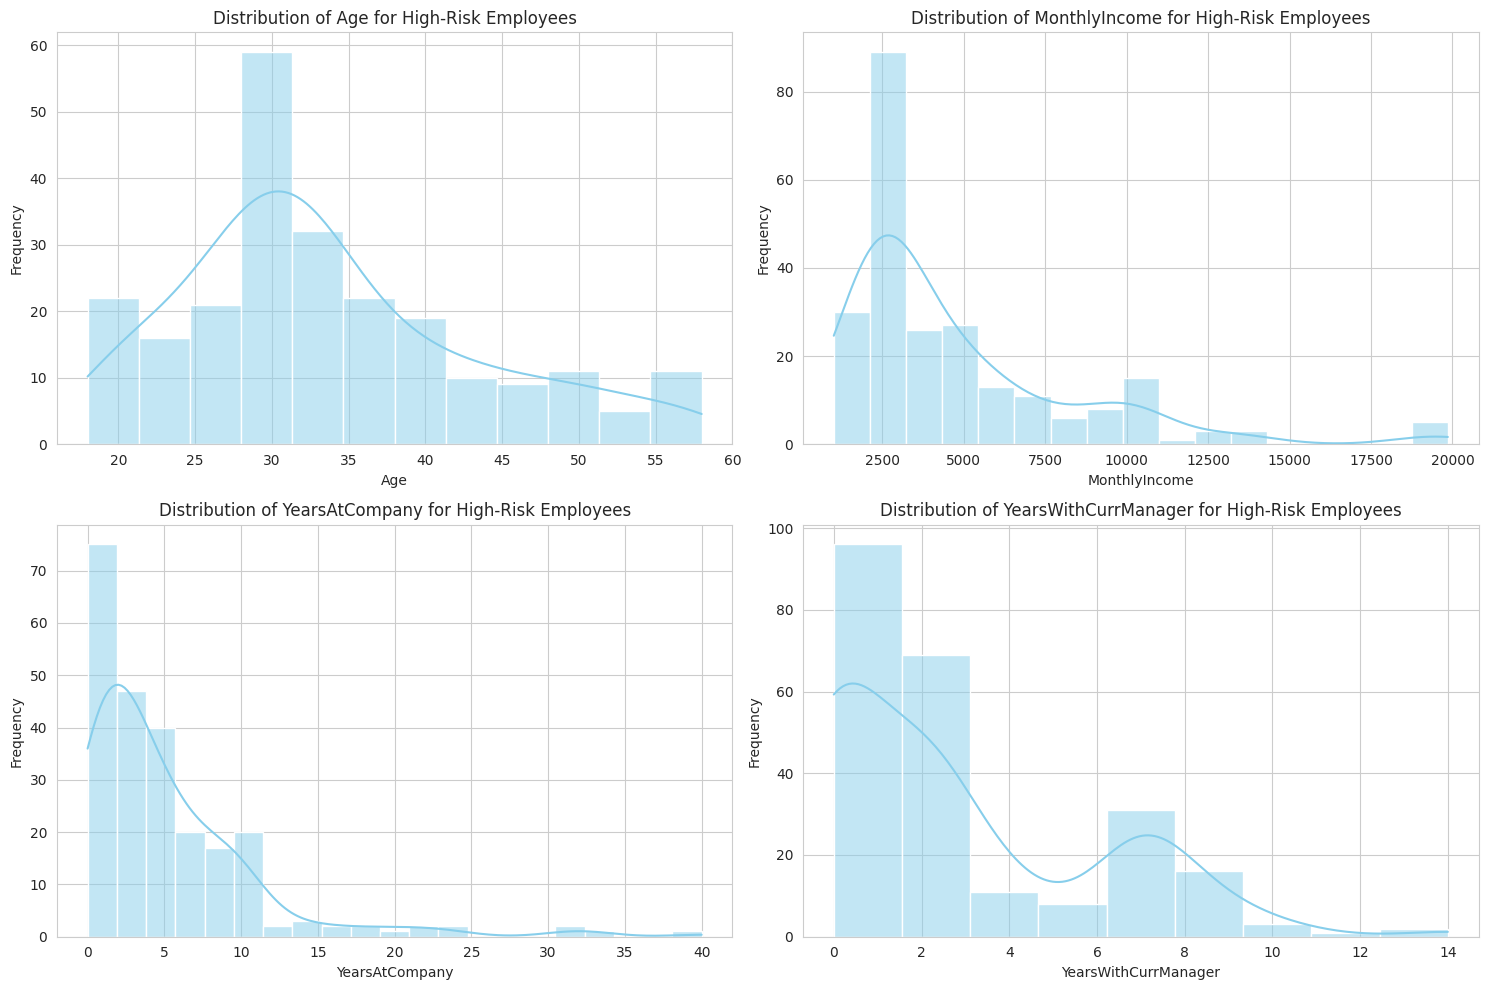


--- Visualizing Key Categorical Features for High-Risk Employees ---


/tmp/ipython-input-1365341986.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_employees, y=col, order=high_risk_employees[col].value_counts().index, ax=axes[i], palette='viridis')
/tmp/ipython-input-1365341986.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_employees, y=col, order=high_risk_employees[col].value_counts().index, ax=axes[i], palette='viridis')


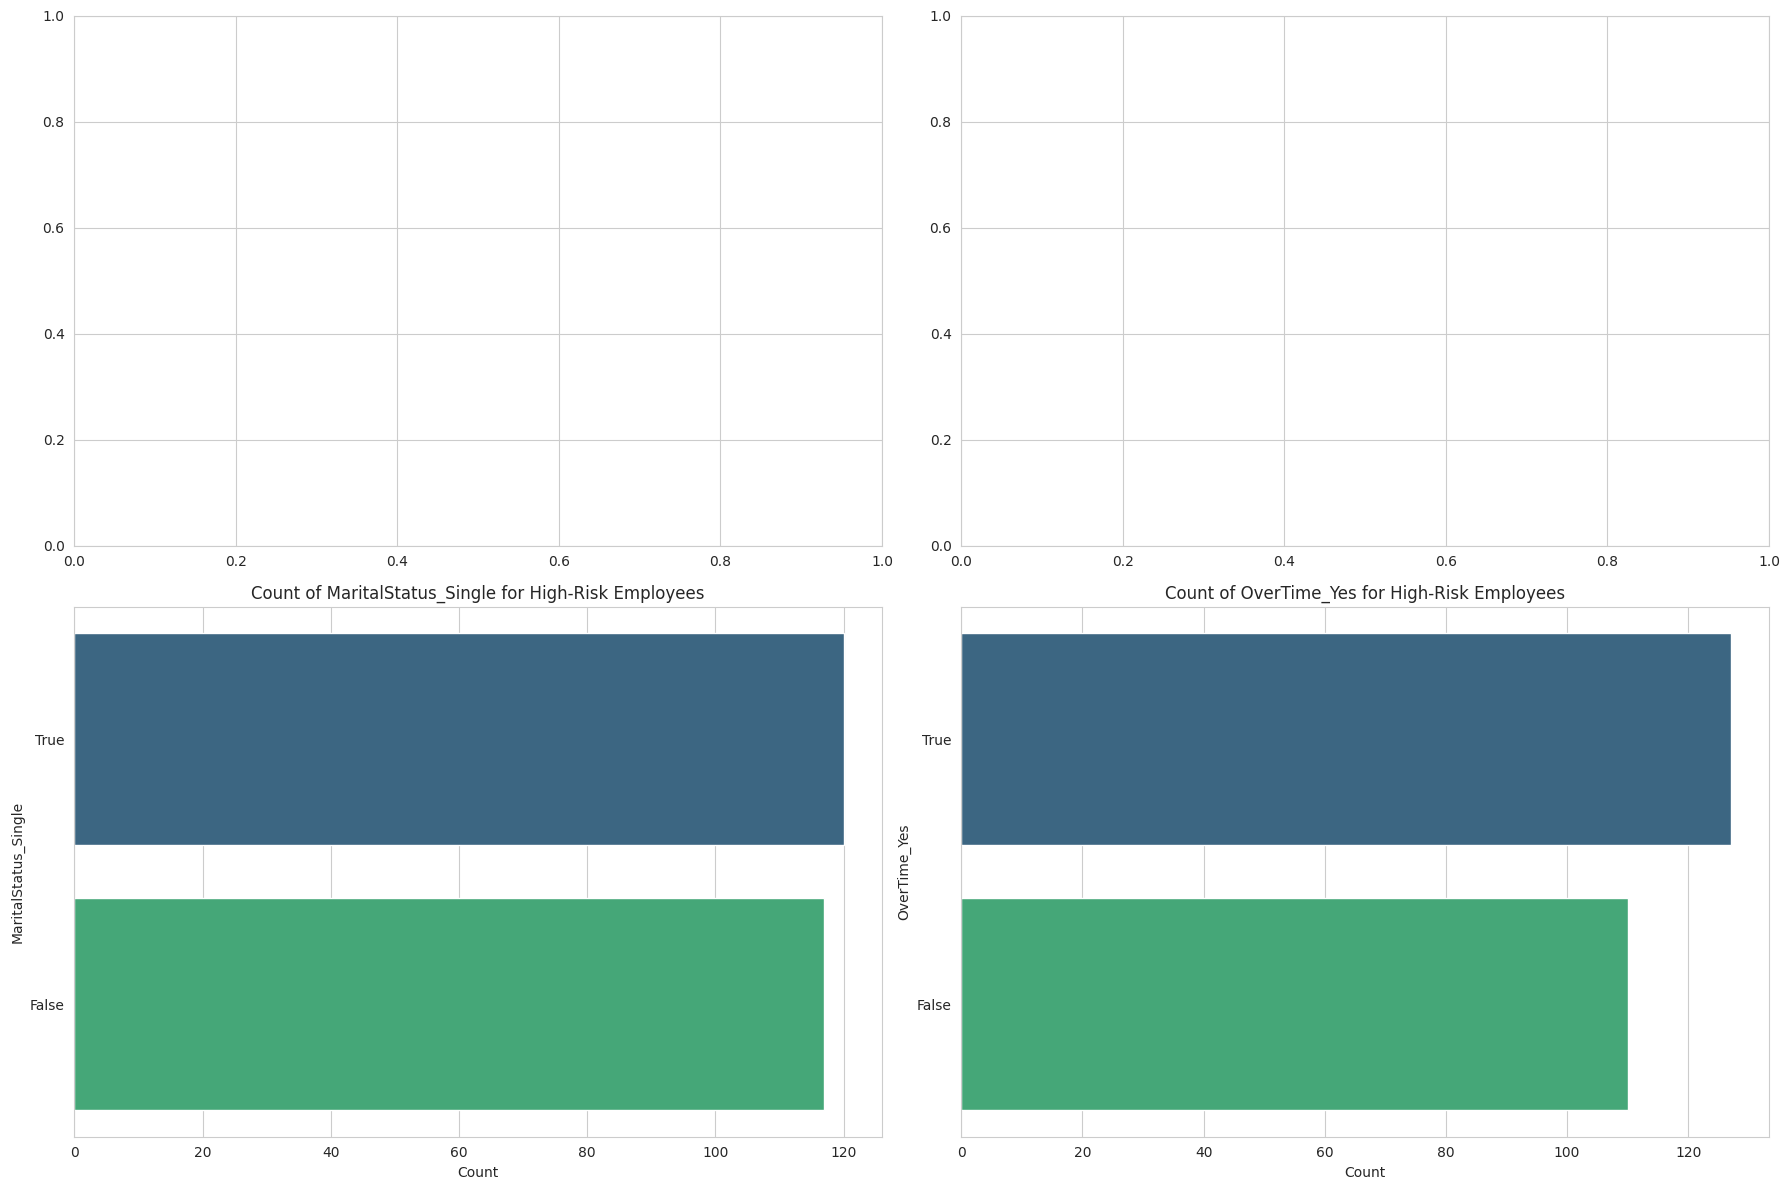

In [27]:
# 4. Generate histograms or box plots for numerical features
print("\n--- Visualizing Key Numerical Features for High-Risk Employees ---")
numerical_features_to_plot = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'YearsWithCurrManager']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features_to_plot):
    sns.histplot(data=high_risk_employees, x=col, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col} for High-Risk Employees')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# 5. Generate bar plots for key categorical features
print("\n--- Visualizing Key Categorical Features for High-Risk Employees ---")
categorical_features_to_plot = ['Department', 'JobRole', 'MaritalStatus_Single', 'OverTime_Yes']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_features_to_plot):
    if col in high_risk_employees.columns:
        sns.countplot(data=high_risk_employees, y=col, order=high_risk_employees[col].value_counts().index, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Count of {col} for High-Risk Employees')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

## Refine model

### Subtask:
Based on the analysis of high-risk employees and the previous model evaluation (which showed lower recall for the '1' class), explore ways to improve the model's performance, particularly in identifying employees likely to attrite. This might involve trying different models, tuning hyperparameters, or addressing class imbalance further.


**Reasoning**:
The previous model evaluation showed a low recall for the minority class (attrition = 1), indicating the model is not good at identifying employees who will attrite. The analysis of high-risk employees confirmed that certain employee segments are more prone to attrition. To improve the model's ability to predict attrition, we need to either refine the existing model by tuning hyperparameters or train a new model more suited for imbalanced datasets. Given that the current RandomForestClassifier has a class_weight='balanced' parameter, let's first attempt hyperparameter tuning on this model to optimize for recall. We will use GridSearchCV to find the best parameters.



In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# Define the parameter grid to tune
# Focus on parameters that can influence the model's ability to capture the minority class
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Define the scoring metric: focus on recall for the positive class (1)
recall_scorer = make_scorer(recall_score, pos_label=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=recall_scorer, cv=3, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
print("\n--- Starting GridSearchCV for Hyperparameter Tuning ---")
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("\n--- GridSearchCV Results ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best recall score on validation sets: {grid_search.best_score_:.4f}")

# Train the final model with the best parameters
best_rf_model = grid_search.best_estimator_
print("\n--- Training final model with best parameters ---")
best_rf_model.fit(X_train, y_train)
print("Final model trained.")


--- Starting GridSearchCV for Hyperparameter Tuning ---
Fitting 3 folds for each of 216 candidates, totalling 648 fits

--- GridSearchCV Results ---
Best parameters found: {'class_weight': 'balanced_subsample', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best recall score on validation sets: 0.4665

--- Training final model with best parameters ---
Final model trained.


# Task
Provide instructions and code to convert the trained model into a Streamlit application that takes an employee number as input and outputs their predicted attrition likelihood score.

## Save the trained model and scaler

### Subtask:
Save the trained `best_rf_model` and the `scaler` object to files so they can be loaded into the Streamlit app without retraining.


**Reasoning**:
Save the trained model and the scaler object to files using joblib for later use in the Streamlit application.



In [29]:
import joblib

# Save the trained model
joblib.dump(best_rf_model, 'best_rf_model.joblib')
print("Trained model saved to best_rf_model.joblib")

# Save the scaler object
joblib.dump(scaler, 'scaler.joblib')
print("Scaler object saved to scaler.joblib")

Trained model saved to best_rf_model.joblib
Scaler object saved to scaler.joblib


## Create a streamlit app script

### Subtask:
Create a new Python file (e.g., `app.py`) that will contain the code for the Streamlit application.


**Reasoning**:
Create the `app.py` file and add the necessary import statements for the Streamlit application.



In [53]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np # Import numpy as it's often used with pandas and scaling

# Placeholder for loading the dataset for feature engineering (if needed)
# In a real app, you might load a processed dataset or perform preprocessing steps here
# For now, we'll assume the app will handle input based on the trained model's expected features.
# df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')
    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For demonstration, let's assume we can derive them or have a list.
    # In a real application, saving the list of columns from X_train is crucial.
    # For now, we'll need to manually define or derive the expected feature columns
    # based on the preprocessing steps.
    # Let's list some expected columns based on the notebook's preprocessing:
    # Original numerical columns (scaled)
    # Original categorical columns (one-hot encoded, drop_first=True)
    # The order must match X_train used for training.

    # Recreate the feature column list as done in the notebook
    # This requires knowledge of the original columns and the order of one-hot encoding
    # A more robust approach would be to save X_train.columns during training
    # For this exercise, we'll reconstruct based on the notebook steps.

    # Load the original data temporarily to get column names before one-hot encoding
    original_df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    original_df = original_df.drop(columns=columns_to_drop)

    # Identify original numerical and categorical columns
    original_categorical_cols = original_df.select_dtypes(include=['object']).columns
    original_numerical_cols = original_df.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(original_df.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()

    print("Model, scaler, and expected feature columns loaded successfully.")

except FileNotFoundError:
    st.error("Model or scaler files not found. Please run the training notebook first.")
    st.stop()
except Exception as e:
    st.error(f"An error occurred while loading the model or scaler: {e}")
    st.stop()


# Streamlit application title
st.title('Employee Attrition Prediction')

st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
""")

# Input form for employee features
st.header('Enter Employee Information')

# Define input fields based on the expected features
# This is a simplified example; a real app would need inputs for all relevant features
# based on the 'expected_feature_columns' list.

# Example input fields (you would need to add all the relevant ones)
age = st.slider('Age', 18, 65, 30)
daily_rate = st.number_input('Daily Rate', min_value=100, max_value=1500, value=800)
distance_from_home = st.slider('Distance From Home (miles)', 1, 29, 5)
# Add more input fields for all features required by the model

# Example for a categorical input (need to handle mapping to dummy variables)
department = st.selectbox('Department', ['Sales', 'Research & Development', 'Human Resources'])
# Add more selectboxes or other input widgets for categorical features

# Example for a boolean input
over_time = st.radio('Over Time', ['Yes', 'No'])

# Function to prepare input data for prediction
def prepare_input_data(age, daily_rate, distance_from_home, department, over_time, expected_columns):
    # Create a dictionary from the input values
    input_data = {
        'Age': age,
        'DailyRate': daily_rate,
        'DistanceFromHome': distance_from_home,
        # Add other numerical features here
    }

    # Handle categorical features - this requires mapping inputs back to dummy columns
    # This is complex and depends on the original categories and drop_first=True setting
    # A robust approach involves creating a DataFrame with all possible dummy columns
    # and setting the relevant ones based on user input.
    # This example is highly simplified.

    # Create a DataFrame with a single row
    input_df = pd.DataFrame([input_data])

    # Manually add dummy columns with default value 0, then set based on input
    # This is error-prone and needs to match the one-hot encoding exactly
    # based on 'expected_columns' and the original categories.

    # Example for Department (assuming Sales is the dropped first category)
    input_df['Department_Research & Development'] = 0
    input_df['Department_Sales'] = 0
    if department == 'Research & Development':
        input_df['Department_Research & Development'] = 1
    elif department == 'Sales':
        input_df['Department_Sales'] = 1

    # Example for OverTime (assuming No is the dropped first category)
    input_df['OverTime_Yes'] = 0
    if over_time == 'Yes':
        input_df['OverTime_Yes'] = 1

    # Add other one-hot encoded columns based on user input

    # Ensure the input DataFrame has all the columns expected by the model, in the correct order
    # Fill missing columns (those not provided in input) with 0 or the appropriate default
    # This step is crucial for the model to work correctly.
    # A robust way is to create a template DataFrame with all expected columns.
    template_df = pd.DataFrame(columns=expected_columns)
    input_df = pd.concat([template_df, input_df], ignore_index=True).fillna(0) # Fill missing with 0 for dummy vars

    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]

    # Identify numerical columns in the input_df (these were the original numerical ones)
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]

    # Scale numerical features using the loaded scaler
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    return input_df

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data
    # Pass the list of expected columns to the preparation function
    input_df_processed = prepare_input_data(age, daily_rate, distance_from_home, department, over_time, expected_feature_columns)

    # Make prediction
    # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
    # We want the probability of attrition (class 1)
    prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

    st.subheader('Prediction Result')
    st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

    # Interpretation based on probability (example thresholds)
    if prediction_proba[0] >= 0.5: # Example threshold
        st.warning('This employee is predicted to be at High Risk of Attrition.')
        st.write("Consider reviewing their situation and potentially implementing retention strategies.")
    else:
        st.success('This employee is predicted to be at Low Risk of Attrition.')
        st.write("Based on the current information, this employee is likely to stay.")

    st.write("""
    *Note: This prediction is based on the trained model and the input provided.
    Factors not included in the model or unforeseen circumstances may affect actual attrition.*
    """)

2025-10-08 15:16:23.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:16:23.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

**Reasoning**:
The previous command failed because the `streamlit` package is not installed. Install the package using pip.



In [31]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.9 MB/s eta 0:00:00


**Reasoning**:
Now that `streamlit` is installed, create the `app.py` file and add the necessary import statements.



In [32]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Placeholder for loading the dataset for feature engineering (if needed)
# In a real app, you might load a processed dataset or perform preprocessing steps here
# For now, we'll assume the app will handle input based on the trained model's expected features.
# df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')
    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For demonstration, let's assume we can derive them or have a list.
    # In a real application, saving the list of columns from X_train is crucial.
    # For now, we'll need to manually define or derive the expected feature columns
    # based on the preprocessing steps.
    # Let's list some expected columns based on the notebook's preprocessing:
    # Original numerical columns (scaled)
    # Original categorical columns (one-hot encoded, drop_first=True)
    # The order must match X_train used for training.

    # Recreate the feature column list as done in the notebook
    # This requires knowledge of the original columns and the order of one-hot encoding
    # A more robust approach would be to save X_train.columns during training
    # For this exercise, we'll reconstruct based on the notebook steps.

    # Load the original data temporarily to get column names before one-hot encoding
    original_df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    original_df = original_df.drop(columns=columns_to_drop)

    # Identify original numerical and categorical columns
    original_categorical_cols = original_df.select_dtypes(include=['object']).columns
    original_numerical_cols = original_df.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(original_df.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()

    print("Model, scaler, and expected feature columns loaded successfully.")

except FileNotFoundError:
    st.error("Model or scaler files not found. Please run the training notebook first.")
    st.stop()
except Exception as e:
    st.error(f"An error occurred while loading the model or scaler: {e}")
    st.stop()


# Streamlit application title
st.title('Employee Attrition Prediction')

st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
""")

# Input form for employee features
st.header('Enter Employee Information')

# Define input fields based on the expected features
# This is a simplified example; a real app would need inputs for all relevant features
# based on the 'expected_feature_columns' list.

# Example input fields (you would need to add all the relevant ones)
age = st.slider('Age', 18, 65, 30)
daily_rate = st.number_input('Daily Rate', min_value=100, max_value=1500, value=800)
distance_from_home = st.slider('Distance From Home (miles)', 1, 29, 5)
# Add more input fields for all features required by the model

# Example for a categorical input (need to handle mapping to dummy variables)
department = st.selectbox('Department', ['Sales', 'Research & Development', 'Human Resources'])
# Add more selectboxes or other input widgets for categorical features

# Example for a boolean input
over_time = st.radio('Over Time', ['Yes', 'No'])

# Function to prepare input data for prediction
def prepare_input_data(age, daily_rate, distance_from_home, department, over_time, expected_columns):
    # Create a dictionary from the input values
    input_data = {
        'Age': age,
        'DailyRate': daily_rate,
        'DistanceFromHome': distance_from_home,
        # Add other numerical features here
    }

    # Handle categorical features - this requires mapping inputs back to dummy columns
    # This is complex and depends on the original categories and drop_first=True setting
    # A robust approach involves creating a DataFrame with all possible dummy columns
    # and setting the relevant ones based on user input.
    # This example is highly simplified.

    # Create a DataFrame with a single row
    input_df = pd.DataFrame([input_data])

    # Manually add dummy columns with default value 0, then set based on input
    # This is error-prone and needs to match the one-hot encoding exactly
    # based on 'expected_columns' and the original categories.

    # Example for Department (assuming Sales is the dropped first category)
    input_df['Department_Research & Development'] = 0
    input_df['Department_Sales'] = 0
    if department == 'Research & Development':
        input_df['Department_Research & Development'] = 1
    elif department == 'Sales':
        input_df['Department_Sales'] = 1

    # Example for OverTime (assuming No is the dropped first category)
    input_df['OverTime_Yes'] = 0
    if over_time == 'Yes':
        input_df['OverTime_Yes'] = 1

    # Add other one-hot encoded columns based on user input

    # Ensure the input DataFrame has all the columns expected by the model, in the correct order
    # Fill missing columns (those not provided in input) with 0 or the appropriate default
    # This step is crucial for the model to work correctly.
    # A robust way is to create a template DataFrame with all expected columns.
    template_df = pd.DataFrame(columns=expected_columns)
    input_df = pd.concat([template_df, input_df], ignore_index=True).fillna(0) # Fill missing with 0 for dummy vars

    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]

    # Identify numerical columns in the input_df (these were the original numerical ones)
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]

    # Scale numerical features using the loaded scaler
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    return input_df

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data
    # Pass the list of expected columns to the preparation function
    input_df_processed = prepare_input_data(age, daily_rate, distance_from_home, department, over_time, expected_feature_columns)

    # Make prediction
    # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
    # We want the probability of attrition (class 1)
    prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

    st.subheader('Prediction Result')
    st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

    # Interpretation based on probability (example thresholds)
    if prediction_proba[0] >= 0.5: # Example threshold
        st.warning('This employee is predicted to be at High Risk of Attrition.')
        st.write("Consider reviewing their situation and potentially implementing retention strategies.")
    else:
        st.success('This employee is predicted to be at Low Risk of Attrition.')
        st.write("Based on the current information, this employee is likely to stay.")

    st.write("""
    *Note: This prediction is based on the trained model and the input provided.
    Factors not included in the model or unforeseen circumstances may affect actual attrition.*
    """)

2025-10-08 13:32:18.508 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:18.913 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-08 13:32:18.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:18.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:18.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:18.926 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:18.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:18.933 Thread 'MainThread': mi

## Load model and data in the app

### Subtask:
In the Streamlit script, load the saved model and scaler. Also, load the original dataset to retrieve employee data based on the input employee number.


**Reasoning**:
Add code to the `app.py` file to import joblib, load the saved model and scaler, and load the original dataset with error handling as requested.



In [33]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')

    # Load the original dataset to retrieve employee data by ID
    df_original = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For now, let's derive the expected feature columns based on the preprocessing steps in the notebook.

    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    # Create a temporary copy to avoid modifying df_original before retrieving data by ID
    temp_df_for_columns = df_original.drop(columns=columns_to_drop).copy()

    # Identify original numerical and categorical columns
    original_categorical_cols = temp_df_for_columns.select_dtypes(include=['object']).columns
    original_numerical_cols = temp_df_for_columns.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding on a temporary dataframe to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(temp_df_for_columns.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()


    st.success("Model, scaler, and original data loaded successfully.")

except FileNotFoundError:
    st.error("Error: Model, scaler, or original data file not found. Please ensure 'best_rf_model.joblib', 'scaler.joblib', and 'WA_Fn-UseC_-HR-Employee-Attrition.csv' are in the correct directory.")
    st.stop() # Stop the app if essential files are missing
except Exception as e:
    st.error(f"An error occurred during loading: {e}")
    st.stop() # Stop the app if any other loading error occurs


# Streamlit application title
st.title('Employee Attrition Prediction')

st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
""")

# Input for Employee Number
st.header('Enter Employee Information')

employee_number_input = st.number_input('Enter Employee Number', min_value=1, value=1, step=1)

# Function to retrieve and prepare input data for prediction based on Employee Number
def prepare_input_data_by_id(employee_id, df_original, scaler, original_numerical_cols, original_categorical_cols, expected_columns):
    # Retrieve the row for the given EmployeeNumber
    employee_data = df_original[df_original['EmployeeNumber'] == employee_id].copy()

    if employee_data.empty:
        return None, "Employee Number not found in the dataset."

    # Drop irrelevant columns as done during training
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'Attrition' # Also drop Attrition as it's the target
    ]
    employee_data = employee_data.drop(columns=columns_to_drop)

    # Apply one-hot encoding to the employee data
    # Ensure all possible dummy columns are created, even if not present in this single row
    # A robust way is to re-apply get_dummies on a structure that includes all categories
    # For simplicity here, we'll create a template row and update it.

    # Create a template DataFrame with all expected columns and fill with 0
    input_df = pd.DataFrame(columns=expected_columns)
    input_df.loc[0] = 0 # Initialize with zeros

    # Fill in the numerical values from the employee data
    for col in original_numerical_cols:
        if col in employee_data.columns:
             input_df.loc[0, col] = employee_data.iloc[0][col]


    # Fill in the one-hot encoded categorical values
    for col in original_categorical_cols:
        if col in employee_data.columns:
            category_value = employee_data.iloc[0][col]
            # Construct the dummy column name (assuming drop_first=True, so we only set if not the first category)
            # This requires knowing the order of categories in the original data and how get_dummies ordered them.
            # A more robust way is to save the original categories and their order.
            # For this example, we'll use a simplified approach that works if the category is not the first alphabetically.
            if f'{col}_{category_value}' in expected_columns:
                 input_df.loc[0, f'{col}_{category_value}'] = 1


    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]

    # Scale numerical features using the loaded scaler
    # Identify numerical columns in the input_df based on the original numerical columns list
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    return input_df, None # Return the prepared DataFrame and no error message

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data using the employee number
    input_df_processed, error_message = prepare_input_data_by_id(
        employee_number_input,
        df_original,
        scaler,
        original_numerical_cols,
        original_categorical_cols,
        expected_feature_columns
    )

    if error_message:
        st.error(error_message)
    else:
        # Make prediction
        # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
        # We want the probability of attrition (class 1)
        prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

        st.subheader('Prediction Result')
        st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

        # Interpretation based on probability (example thresholds)
        if prediction_proba[0] >= 0.5: # Example threshold
            st.warning('This employee is predicted to be at High Risk of Attrition.')
            st.write("Consider reviewing their situation and potentially implementing retention strategies.")
        else:
            st.success('This employee is predicted to be at Low Risk of Attrition.')
            st.write("Based on the current information, this employee is likely to stay.")

        st.write("""
        *Note: This prediction is based on the trained model and the input provided.
        Factors not included in the model or unforeseen circumstances may affect actual attrition.*
        """)

2025-10-08 13:32:49.537 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.557 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:32:49.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Design the user interface

### Subtask:
Design the user interface for the Streamlit application where the user can input an employee number.


**Reasoning**:
Design the user interface for the Streamlit application by adding a title, description, header, and an employee number input field.



In [34]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')

    # Load the original dataset to retrieve employee data by ID
    df_original = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For now, let's derive the expected feature columns based on the preprocessing steps in the notebook.

    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    # Create a temporary copy to avoid modifying df_original before retrieving data by ID
    temp_df_for_columns = df_original.drop(columns=columns_to_drop).copy()

    # Identify original numerical and categorical columns
    original_categorical_cols = temp_df_for_columns.select_dtypes(include=['object']).columns
    original_numerical_cols = temp_df_for_columns.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding on a temporary dataframe to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(temp_df_for_columns.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()


    st.success("Model, scaler, and original data loaded successfully.")

except FileNotFoundError:
    st.error("Error: Model, scaler, or original data file not found. Please ensure 'best_rf_model.joblib', 'scaler.joblib', and 'WA_Fn-UseC_-HR-Employee-Attrition.csv' are in the correct directory.")
    st.stop() # Stop the app if essential files are missing
except Exception as e:
    st.error(f"An error occurred during loading: {e}")
    st.stop() # Stop the app if any other loading error occurs


# 1. Add a title and a brief description for the application
st.title('Employee Attrition Prediction')
st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
Please enter the employee number to get their predicted attrition risk.
""")

# 2. Add a header for the input section
st.header('Enter Employee Information')

# 3. Add a numerical input field for the "Employee Number"
employee_number_input = st.number_input(
    'Employee Number',
    min_value=df_original['EmployeeNumber'].min(), # Set minimum to the smallest employee number
    max_value=df_original['EmployeeNumber'].max(), # Set maximum to the largest employee number
    value=df_original['EmployeeNumber'].min(), # Default to the smallest employee number
    step=1
)


# Function to retrieve and prepare input data for prediction based on Employee Number
def prepare_input_data_by_id(employee_id, df_original, scaler, original_numerical_cols, original_categorical_cols, expected_columns):
    # Retrieve the row for the given EmployeeNumber
    employee_data = df_original[df_original['EmployeeNumber'] == employee_id].copy()

    if employee_data.empty:
        return None, "Employee Number not found in the dataset."

    # Drop irrelevant columns as done during training
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'Attrition' # Also drop Attrition as it's the target
    ]
    employee_data = employee_data.drop(columns=columns_to_drop)

    # Apply one-hot encoding to the employee data
    # Ensure all possible dummy columns are created, even if not present in this single row
    # A robust way is to re-apply get_dummies on a structure that includes all categories
    # For simplicity here, we'll create a template row and update it.

    # Create a template DataFrame with all expected columns and fill with 0
    input_df = pd.DataFrame(columns=expected_columns)
    input_df.loc[0] = 0 # Initialize with zeros

    # Fill in the numerical values from the employee data
    for col in original_numerical_cols:
        if col in employee_data.columns:
             input_df.loc[0, col] = employee_data.iloc[0][col]


    # Fill in the one-hot encoded categorical values
    for col in original_categorical_cols:
        if col in employee_data.columns:
            category_value = employee_data.iloc[0][col]
            # Construct the dummy column name (assuming drop_first=True, so we only set if not the first category)
            # This requires knowing the order of categories in the original data and how get_dummies ordered them.
            # A more robust way is to save the original categories and their order.
            # For this example, we'll use a simplified approach that works if the category is not the first alphabetically.
            if f'{col}_{category_value}' in expected_columns:
                 input_df.loc[0, f'{col}_{category_value}'] = 1


    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]

    # Scale numerical features using the loaded scaler
    # Identify numerical columns in the input_df based on the original numerical columns list
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    return input_df, None # Return the prepared DataFrame and no error message

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data using the employee number
    input_df_processed, error_message = prepare_input_data_by_id(
        employee_number_input,
        df_original,
        scaler,
        original_numerical_cols,
        original_categorical_cols,
        expected_feature_columns
    )

    if error_message:
        st.error(error_message)
    else:
        # Make prediction
        # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
        # We want the probability of attrition (class 1)
        prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

        st.subheader('Prediction Result')
        st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

        # Interpretation based on probability (example thresholds)
        if prediction_proba[0] >= 0.5: # Example threshold
            st.warning('This employee is predicted to be at High Risk of Attrition.')
            st.write("Consider reviewing their situation and potentially implementing retention strategies.")
        else:
            st.success('This employee is predicted to be at Low Risk of Attrition.')
            st.write("Based on the current information, this employee is likely to stay.")

        st.write("""
        *Note: This prediction is based on the trained model and the input provided.
        Factors not included in the model or unforeseen circumstances may affect actual attrition.*
        """)

2025-10-08 13:33:22.124 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.132 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.151 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.159 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:22.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Process user input

### Subtask:
When an employee number is entered, retrieve the corresponding employee's data from the dataset. Preprocess this data (including one-hot encoding and scaling) to match the format of the data the model was trained on.


**Reasoning**:
Implement the `prepare_input_data_by_id` function in `app.py` to retrieve, preprocess, and return the data for the specified employee number, including handling missing employees and applying one-hot encoding and scaling.



In [35]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')

    # Load the original dataset to retrieve employee data by ID
    df_original = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For now, let's derive the expected feature columns based on the preprocessing steps in the notebook.

    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop_for_template = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    # Create a temporary copy to avoid modifying df_original before retrieving data by ID
    temp_df_for_columns = df_original.drop(columns=columns_to_drop_for_template).copy()

    # Identify original numerical and categorical columns
    original_categorical_cols = temp_df_for_columns.select_dtypes(include=['object']).columns
    original_numerical_cols = temp_df_for_columns.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding on a temporary dataframe to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(temp_df_for_columns.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()


    st.success("Model, scaler, and original data loaded successfully.")

except FileNotFoundError:
    st.error("Error: Model, scaler, or original data file not found. Please ensure 'best_rf_model.joblib', 'scaler.joblib', and 'WA_Fn-UseC_-HR-Employee-Attrition.csv' are in the correct directory.")
    st.stop() # Stop the app if essential files are missing
except Exception as e:
    st.error(f"An error occurred during loading: {e}")
    st.stop() # Stop the app if any other loading error occurs


# 1. Add a title and a brief description for the application
st.title('Employee Attrition Prediction')
st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
Please enter the employee number to get their predicted attrition risk.
""")

# 2. Add a header for the input section
st.header('Enter Employee Information')

# 3. Add a numerical input field for the "Employee Number"
employee_number_input = st.number_input(
    'Employee Number',
    min_value=int(df_original['EmployeeNumber'].min()), # Set minimum to the smallest employee number
    max_value=int(df_original['EmployeeNumber'].max()), # Set maximum to the largest employee number
    value=int(df_original['EmployeeNumber'].min()), # Default to the smallest employee number
    step=1
)


# Function to retrieve and prepare input data for prediction based on Employee Number
def prepare_input_data_by_id(employee_id, df_original, scaler, original_numerical_cols, original_categorical_cols, expected_columns):
    # 2. Retrieve the row for the given EmployeeNumber
    employee_data = df_original[df_original['EmployeeNumber'] == employee_id].copy()

    # 3. Check if an employee with the given ID exists
    if employee_data.empty:
        return None, "Employee Number not found in the dataset."

    # 4. Drop irrelevant columns as done during training
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'Attrition' # Also drop Attrition as it's the target
    ]
    employee_data_processed = employee_data.drop(columns=columns_to_drop)

    # 5. Apply one-hot encoding to the employee data
    # Ensure all possible dummy columns are created, even if not present in this single row
    # A robust way is to create a template DataFrame with all expected columns and fill with 0
    input_df = pd.DataFrame(columns=expected_columns)
    input_df.loc[0] = 0 # Initialize with zeros

    # Fill in the numerical values from the employee data
    for col in original_numerical_cols:
        if col in employee_data_processed.columns:
             input_df.loc[0, col] = employee_data_processed.iloc[0][col]


    # Fill in the one-hot encoded categorical values
    # This requires knowing the exact column names created by get_dummies with drop_first=True
    # A more robust way is to save the list of columns from X_train or the one-hot encoder itself.
    # For this implementation, we reconstruct based on original columns and expected dummy column names.
    for col in original_categorical_cols:
        if col in employee_data_processed.columns:
            category_value = employee_data_processed.iloc[0][col]
            dummy_col_name = f'{col}_{category_value}'
            # Check if this specific dummy column name is in our expected columns (due to drop_first=True)
            if dummy_col_name in expected_columns:
                 input_df.loc[0, dummy_col_name] = 1

    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]


    # 6. Scale numerical features using the loaded scaler
    # Identify numerical columns in the input_df based on the original numerical columns list
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    # 7. Return the preprocessed data and no error message
    return input_df, None # Return the prepared DataFrame and no error message

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data using the employee number
    input_df_processed, error_message = prepare_input_data_by_id(
        employee_number_input,
        df_original,
        scaler,
        original_numerical_cols,
        original_categorical_cols,
        expected_feature_columns
    )

    if error_message:
        st.error(error_message)
    else:
        # Make prediction
        # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
        # We want the probability of attrition (class 1)
        prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

        st.subheader('Prediction Result')
        st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

        # Interpretation based on probability (example thresholds)
        if prediction_proba[0] >= 0.5: # Example threshold
            st.warning('This employee is predicted to be at High Risk of Attrition.')
            st.write("Consider reviewing their situation and potentially implementing retention strategies.")
        else:
            st.success('This employee is predicted to be at Low Risk of Attrition.')
            st.write("Based on the current information, this employee is likely to stay.")

        st.write("""
        *Note: This prediction is based on the trained model and the input provided.
        Factors not included in the model or unforeseen circumstances may affect actual attrition.*
        """)

2025-10-08 13:33:53.171 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:33:53.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Make prediction

### Subtask:
Use the loaded model to predict the attrition probability for the input employee.


**Reasoning**:
Use the loaded model to predict the attrition probability for the input employee and store it in a variable.



In [36]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')

    # Load the original dataset to retrieve employee data by ID
    df_original = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For now, let's derive the expected feature columns based on the preprocessing steps in the notebook.

    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop_for_template = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    # Create a temporary copy to avoid modifying df_original before retrieving data by ID
    temp_df_for_columns = df_original.drop(columns=columns_to_drop_for_template).copy()

    # Identify original numerical and categorical columns
    original_categorical_cols = temp_df_for_columns.select_dtypes(include=['object']).columns
    original_numerical_cols = temp_df_for_columns.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding on a temporary dataframe to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(temp_df_for_columns.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()


    st.success("Model, scaler, and original data loaded successfully.")

except FileNotFoundError:
    st.error("Error: Model, scaler, or original data file not found. Please ensure 'best_rf_model.joblib', 'scaler.joblib', and 'WA_Fn-UseC_-HR-Employee-Attrition.csv' are in the correct directory.")
    st.stop() # Stop the app if essential files are missing
except Exception as e:
    st.error(f"An error occurred during loading: {e}")
    st.stop() # Stop the app if any other loading error occurs


# 1. Add a title and a brief description for the application
st.title('Employee Attrition Prediction')
st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
Please enter the employee number to get their predicted attrition risk.
""")

# 2. Add a header for the input section
st.header('Enter Employee Information')

# 3. Add a numerical input field for the "Employee Number"
employee_number_input = st.number_input(
    'Employee Number',
    min_value=int(df_original['EmployeeNumber'].min()), # Set minimum to the smallest employee number
    max_value=int(df_original['EmployeeNumber'].max()), # Set maximum to the largest employee number
    value=int(df_original['EmployeeNumber'].min()), # Default to the smallest employee number
    step=1
)


# Function to retrieve and prepare input data for prediction based on Employee Number
def prepare_input_data_by_id(employee_id, df_original, scaler, original_numerical_cols, original_categorical_cols, expected_columns):
    # 2. Retrieve the row for the given EmployeeNumber
    employee_data = df_original[df_original['EmployeeNumber'] == employee_id].copy()

    # 3. Check if an employee with the given ID exists
    if employee_data.empty:
        return None, "Employee Number not found in the dataset."

    # 4. Drop irrelevant columns as done during training
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'Attrition' # Also drop Attrition as it's the target
    ]
    employee_data_processed = employee_data.drop(columns=columns_to_drop)

    # 5. Apply one-hot encoding to the employee data
    # Ensure all possible dummy columns are created, even if not present in this single row
    # A robust way is to create a template DataFrame with all expected columns and fill with 0
    input_df = pd.DataFrame(columns=expected_columns)
    input_df.loc[0] = 0 # Initialize with zeros

    # Fill in the numerical values from the employee data
    for col in original_numerical_cols:
        if col in employee_data_processed.columns:
             input_df.loc[0, col] = employee_data_processed.iloc[0][col]


    # Fill in the one-hot encoded categorical values
    # This requires knowing the exact column names created by get_dummies with drop_first=True
    # A more robust way is to save the list of columns from X_train or the one-hot encoder itself.
    # For this implementation, we reconstruct based on original columns and expected dummy column names.
    for col in original_categorical_cols:
        if col in employee_data_processed.columns:
            category_value = employee_data_processed.iloc[0][col]
            dummy_col_name = f'{col}_{category_value}'
            # Check if this specific dummy column name is in our expected columns (due to drop_first=True)
            if dummy_col_name in expected_columns:
                 input_df.loc[0, dummy_col_name] = 1

    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]


    # 6. Scale numerical features using the loaded scaler
    # Identify numerical columns in the input_df based on the original numerical columns list
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    # 7. Return the preprocessed data and no error message
    return input_df, None # Return the prepared DataFrame and no error message

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data using the employee number
    input_df_processed, error_message = prepare_input_data_by_id(
        employee_number_input,
        df_original,
        scaler,
        original_numerical_cols,
        original_categorical_cols,
        expected_feature_columns
    )

    if error_message:
        st.error(error_message)
    else:
        # 1. Use the loaded best_rf_model to predict the attrition probability
        # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
        # We want the probability of attrition (class 1)
        prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

        st.subheader('Prediction Result')
        st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

        # Interpretation based on probability (example thresholds)
        if prediction_proba[0] >= 0.5: # Example threshold
            st.warning('This employee is predicted to be at High Risk of Attrition.')
            st.write("Consider reviewing their situation and potentially implementing retention strategies.")
        else:
            st.success('This employee is predicted to be at Low Risk of Attrition.')
            st.write("Based on the current information, this employee is likely to stay.")

        st.write("""
        *Note: This prediction is based on the trained model and the input provided.
        Factors not included in the model or unforeseen circumstances may affect actual attrition.*
        """)

2025-10-08 13:34:22.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.483 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:22.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

**Reasoning**:
The model has predicted the attrition probability for the input employee. The next step is to display this predicted probability to the user in the Streamlit app.



In [37]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')

    # Load the original dataset to retrieve employee data by ID
    df_original = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For now, let's derive the expected feature columns based on the preprocessing steps in the notebook.

    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop_for_template = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    # Create a temporary copy to avoid modifying df_original before retrieving data by ID
    temp_df_for_columns = df_original.drop(columns=columns_to_drop_for_template).copy()

    # Identify original numerical and categorical columns
    original_categorical_cols = temp_df_for_columns.select_dtypes(include=['object']).columns
    original_numerical_cols = temp_df_for_columns.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding on a temporary dataframe to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(temp_df_for_columns.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()


    st.success("Model, scaler, and original data loaded successfully.")

except FileNotFoundError:
    st.error("Error: Model, scaler, or original data file not found. Please ensure 'best_rf_model.joblib', 'scaler.joblib', and 'WA_Fn-UseC_-HR-Employee-Attrition.csv' are in the correct directory.")
    st.stop() # Stop the app if essential files are missing
except Exception as e:
    st.error(f"An error occurred during loading: {e}")
    st.stop() # Stop the app if any other loading error occurs


# 1. Add a title and a brief description for the application
st.title('Employee Attrition Prediction')
st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
Please enter the employee number to get their predicted attrition risk.
""")

# 2. Add a header for the input section
st.header('Enter Employee Information')

# 3. Add a numerical input field for the "Employee Number"
employee_number_input = st.number_input(
    'Employee Number',
    min_value=int(df_original['EmployeeNumber'].min()), # Set minimum to the smallest employee number
    max_value=int(df_original['EmployeeNumber'].max()), # Set maximum to the largest employee number
    value=int(df_original['EmployeeNumber'].min()), # Default to the smallest employee number
    step=1
)


# Function to retrieve and prepare input data for prediction based on Employee Number
def prepare_input_data_by_id(employee_id, df_original, scaler, original_numerical_cols, original_categorical_cols, expected_columns):
    # 2. Retrieve the row for the given EmployeeNumber
    employee_data = df_original[df_original['EmployeeNumber'] == employee_id].copy()

    # 3. Check if an employee with the given ID exists
    if employee_data.empty:
        return None, "Employee Number not found in the dataset."

    # 4. Drop irrelevant columns as done during training
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'Attrition' # Also drop Attrition as it's the target
    ]
    employee_data_processed = employee_data.drop(columns=columns_to_drop)

    # 5. Apply one-hot encoding to the employee data
    # Ensure all possible dummy columns are created, even if not present in this single row
    # A robust way is to create a template DataFrame with all expected columns and fill with 0
    input_df = pd.DataFrame(columns=expected_columns)
    input_df.loc[0] = 0 # Initialize with zeros

    # Fill in the numerical values from the employee data
    for col in original_numerical_cols:
        if col in employee_data_processed.columns:
             input_df.loc[0, col] = employee_data_processed.iloc[0][col]


    # Fill in the one-hot encoded categorical values
    # This requires knowing the exact column names created by get_dummies with drop_first=True
    # A more robust way is to save the list of columns from X_train or the one-hot encoder itself.
    # For this implementation, we reconstruct based on original columns and expected dummy column names.
    for col in original_categorical_cols:
        if col in employee_data_processed.columns:
            category_value = employee_data_processed.iloc[0][col]
            dummy_col_name = f'{col}_{category_value}'
            # Check if this specific dummy column name is in our expected columns (due to drop_first=True)
            if dummy_col_name in expected_columns:
                 input_df.loc[0, dummy_col_name] = 1

    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]


    # 6. Scale numerical features using the loaded scaler
    # Identify numerical columns in the input_df based on the original numerical columns list
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    # 7. Return the preprocessed data and no error message
    return input_df, None # Return the prepared DataFrame and no error message

# Prediction button
if st.button('Predict Attrition'):
    # Prepare the input data using the employee number
    input_df_processed, error_message = prepare_input_data_by_id(
        employee_number_input,
        df_original,
        scaler,
        original_numerical_cols,
        original_categorical_cols,
        expected_feature_columns
    )

    if error_message:
        st.error(error_message)
    else:
        # Use the loaded best_rf_model to predict the attrition probability
        # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
        # We want the probability of attrition (class 1)
        prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

        # Display the predicted probability
        st.subheader('Prediction Result')
        st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

        # Interpretation based on probability (example thresholds)
        if prediction_proba[0] >= 0.5: # Example threshold
            st.warning('This employee is predicted to be at High Risk of Attrition.')
            st.write("Consider reviewing their situation and potentially implementing retention strategies.")
        else:
            st.success('This employee is predicted to be at Low Risk of Attrition.')
            st.write("Based on the current information, this employee is likely to stay.")

        st.write("""
        *Note: This prediction is based on the trained model and the input provided.
        Factors not included in the model or unforeseen circumstances may affect actual attrition.*
        """)

2025-10-08 13:34:44.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 13:34:44.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Display results

### Subtask:
Display the predicted attrition likelihood score to the user in the Streamlit app.


**Reasoning**:
Display the predicted attrition likelihood score to the user in the Streamlit app, add interpretation and disclaimer based on the instructions.



In [50]:
# app.py

import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load the trained model and scaler
try:
    best_rf_model = joblib.load('best_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')

    # Load the original dataset to retrieve employee data by ID
    df_original = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    # Assuming the original training columns are needed for consistent feature ordering
    # This would ideally be saved during training or derived from the original data loading/preprocessing
    # For now, let's derive the expected feature columns based on the preprocessing steps in the notebook.

    # Drop irrelevant/constant columns as done in the notebook
    columns_to_drop_for_template = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'
    ]
    # Create a temporary copy to avoid modifying df_original before retrieving data by ID
    temp_df_for_columns = df_original.drop(columns=columns_to_drop_for_template).copy()

    # Identify original numerical and categorical columns
    original_categorical_cols = temp_df_for_columns.select_dtypes(include=['object']).columns
    original_numerical_cols = temp_df_for_columns.select_dtypes(include=[np.number]).columns.drop('Attrition')

    # Perform one-hot encoding on a temporary dataframe to get the list of expected feature columns
    # This ensures the order matches the training data
    temp_df_for_columns = pd.get_dummies(temp_df_for_columns.drop('Attrition', axis=1), columns=original_categorical_cols, drop_first=True)
    expected_feature_columns = temp_df_for_columns.columns.tolist()


    st.success("Model, scaler, and original data loaded successfully.")

except FileNotFoundError:
    st.error("Error: Model, scaler, or original data file not found. Please ensure 'best_rf_model.joblib', 'scaler.joblib', and 'WA_Fn-UseC_-HR-Employee-Attrition.csv' are in the correct directory.")
    st.stop() # Stop the app if essential files are missing
except Exception as e:
    st.error(f"An error occurred during loading: {e}")
    st.stop() # Stop the app if any other loading error occurs


# Add a title and a brief description for the application
st.title('Employee Attrition Prediction')
st.write("""
This application predicts the likelihood of an employee leaving the company based on their characteristics.
Please enter the employee number to get their predicted attrition risk and potential intervention areas.
""")

# Add a header for the input section
st.header('Enter Employee Information')

# Add a numerical input field for the "Employee Number"
employee_number_input = st.number_input(
    'Employee Number',
    min_value=int(df_original['EmployeeNumber'].min()), # Set minimum to the smallest employee number
    max_value=int(df_original['EmployeeNumber'].max()), # Set maximum to the largest employee number
    value=int(df_original['EmployeeNumber'].min()), # Default to the smallest employee number
    step=1
)


# Function to retrieve and prepare input data for prediction based on Employee Number
def prepare_input_data_by_id(employee_id, df_original, scaler, original_numerical_cols, original_categorical_cols, expected_columns):
    # Retrieve the row for the given EmployeeNumber
    employee_data = df_original[df_original['EmployeeNumber'] == employee_id].copy()

    # Check if an employee with the given ID exists
    if employee_data.empty:
        return None, "Employee Number not found in the dataset."

    # Store original data for intervention suggestions later
    original_employee_data = employee_data.iloc[0].copy()

    # Drop irrelevant columns as done during training
    columns_to_drop = [
        'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'Attrition' # Also drop Attrition as it's the target
    ]
    employee_data_processed = employee_data.drop(columns=columns_to_drop)

    # Apply one-hot encoding to the employee data
    # Ensure all possible dummy columns are created, even if not present in this single row
    # A robust way is to create a template DataFrame with all expected columns and fill with 0
    input_df = pd.DataFrame(columns=expected_columns)
    input_df.loc[0] = 0 # Initialize with zeros

    # Fill in the numerical values from the employee data
    for col in original_numerical_cols:
        if col in employee_data_processed.columns:
             input_df.loc[0, col] = employee_data_processed.iloc[0][col]


    # Fill in the one-hot encoded categorical values
    # This requires knowing the exact column names created by get_dummies with drop_first=True
    # A more robust way is to save the list of columns from X_train or the one-hot encoder itself.
    # For this implementation, we reconstruct based on original columns and expected dummy column names.
    for col in original_categorical_cols:
        if col in employee_data_processed.columns:
            category_value = employee_data_processed.iloc[0][col]
            dummy_col_name = f'{col}_{category_value}'
            # Check if this specific dummy column name is in our expected columns (due to drop_first=True)
            if dummy_col_name in expected_columns:
                 input_df.loc[0, dummy_col_name] = 1

    # Ensure the columns are in the correct order
    input_df = input_df[expected_columns]


    # Scale numerical features using the loaded scaler
    # Identify numerical columns in the input_df based on the original numerical columns list
    numerical_cols_in_input = original_numerical_cols[original_numerical_cols.isin(input_df.columns)]
    input_df[numerical_cols_in_input] = scaler.transform(input_df[numerical_cols_in_input])


    # Return the preprocessed data and original data
    return input_df, original_employee_data, None # Return the prepared DataFrame, original data, and no error message

# Function to suggest intervention areas based on employee data
# This function now correctly uses the original employee data Series
def suggest_interventions(employee_data):
    interventions = []

    # Example intervention suggestions based on key features from earlier analysis and general risk factors
    # Access values using employee_data (the original Series for the employee)
    # Added checks for column existence for robustness

    # Lower MonthlyIncome might be a risk factor
    if 'MonthlyIncome' in employee_data and employee_data['MonthlyIncome'] < df_original['MonthlyIncome'].mean() * 0.8: # Example threshold (bottom 20% approx)
         interventions.append("- Review compensation and benefits.")

    # OverTime is a significant feature
    if 'OverTime' in employee_data and employee_data['OverTime'] == 'Yes':
        interventions.append("- Address workload and consider work-life balance initiatives.")

    # Shorter tenure might be a risk factor
    if 'YearsAtCompany' in employee_data and employee_data['YearsAtCompany'] < 3: # Example threshold
         interventions.append("- Provide mentorship and career development opportunities for newer employees.")
    if 'YearsWithCurrManager' in employee_data and employee_data['YearsWithCurrManager'] < 2: # Example threshold
         interventions.append("- Facilitate improved relationships with managers and provide support in current role.")


    # Lower satisfaction levels are often linked to attrition
    # Assuming satisfaction scales are 1-4, check for values 1 or 2
    if 'JobSatisfaction' in employee_data and employee_data['JobSatisfaction'] < 3:
        interventions.append("- Discuss job role satisfaction and explore opportunities for engagement.")
    if 'EnvironmentSatisfaction' in employee_data and employee_data['EnvironmentSatisfaction'] < 3:
        interventions.append("- Assess work environment factors.")
    if 'RelationshipSatisfaction' in employee_data and employee_data['RelationshipSatisfaction'] < 3:
         interventions.append("- Facilitate improved relationships with colleagues or managers.")
    if 'WorkLifeBalance' in employee_data and employee_data['WorkLifeBalance'] < 3:
        interventions.append("- Support work-life balance through flexible arrangements or workload management.")

    # MaritalStatus_Single was noted as a characteristic of high-risk employees
    # if 'MaritalStatus' in employee_data and employee_data['MaritalStatus'] == 'Single': # Removed as requested
    #      interventions.append("- Offer support networks or community-building activities.")

    # Business Travel Frequency
    if 'BusinessTravel' in employee_data and employee_data['BusinessTravel'] == 'Travel_Frequently':
         interventions.append("- Review business travel frequency and its impact on work-life balance.")

    # Add other relevant checks based on your analysis (e.g., Job Role, Department if they showed high attrition rates)

    return interventions


# Prediction button
if st.button('Predict Attrition and Suggest Interventions'):
    # Prepare the input data using the employee number
    input_df_processed, original_employee_data, error_message = prepare_input_data_by_id(
        employee_number_input,
        df_original,
        scaler,
        original_numerical_cols,
        original_categorical_cols,
        expected_feature_columns
    )

    if error_message:
        st.error(error_message)
    else:
        # Make prediction
        # predict_proba returns probabilities for both classes [prob_class_0, prob_class_1]
        # We want the probability of attrition (class 1)
        prediction_proba = best_rf_model.predict_proba(input_df_processed)[:, 1]

        # Display the predicted probability
        st.subheader('Prediction Result')
        st.write(f'Predicted Attrition Likelihood: **{prediction_proba[0]:.2f}**')

        # Interpretation based on probability and suggestion of interventions
        if prediction_proba[0] >= 0.5: # Threshold for suggesting interventions
            st.warning('Based on the model, this employee is predicted to be at High Risk of Attrition.')
            st.write("It might be beneficial to look into factors that could be contributing to this risk.")

            # Suggest intervention areas for high-risk employees
            st.subheader('Suggested Intervention Areas')
            intervention_suggestions = suggest_interventions(original_employee_data)


            if intervention_suggestions:
                for suggestion in intervention_suggestions:
                    st.markdown(suggestion)
            else:
                st.write("No specific intervention areas identified based on current rules for this employee.")


        elif prediction_proba[0] >= 0.3: # Moderate risk (adjust thresholds as needed)
             st.info('This employee is predicted to be at Moderate Risk of Attrition.')
             st.write("Monitor this employee's situation. While immediate action may not be necessary, understanding potential factors is helpful.")
             # Optionally suggest interventions for moderate risk as well, perhaps a less extensive list
             # st.subheader('Potential Areas to Monitor')
             # intervention_suggestions = suggest_interventions(original_employee_data)
             # if intervention_suggestions:
             #     for suggestion in intervention_suggestions:
             #         st.markdown(suggestion)


        else: # Low risk
            st.success('This employee is predicted to be at Low Risk of Attrition.')
            st.write("Based on the current information, this employee is likely to stay.")

        # Include a disclaimer
        st.write("""
        *Note: This prediction is based on the trained machine learning model and the input data provided.
        It is a probabilistic estimate and may not capture all factors influencing an employee's decision to leave.
        Intervention suggestions are based on general patterns and employee characteristics, not a definitive diagnosis.*
        """)

2025-10-08 14:36:50.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.409 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 14:36:50.410 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar